In [21]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob
import librosa
import os
import time
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
from skimage import feature
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from sklearn.svm import SVC

train_path = "/kaggle/input/standard-ocr-dataset/data/training_data"
test_path = "/Users/parthivdholaria/Desktop/PARTHIV/IIIT DELHI/SEM5/ML/Project/archive/data/testing_data"

In [ ]:
class_folders = [folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder))]

classwise_imgs_paths = []
for image_dir in class_folders:
    p = [os.path.join(train_path, image_dir, filename) for filename in os.listdir(os.path.join(train_path, image_dir)) if filename.endswith(('.jpg', '.png'))]
    classwise_imgs_paths.append(p)

In [ ]:
from scipy.ndimage import rotate
from skimage.util import random_noise
import cv2

def flip_image(image, axis=0):
    return np.flip(image, axis=axis)

def rotate_image(image, angle):
    return rotate(image, angle, reshape=False, mode='nearest')

def add_random_noise(image, noise_type='gaussian', seed=None):
    if noise_type == 'gaussian':
        noisy_image = random_noise(image, mode='gaussian', seed=seed)
    elif noise_type == 'salt':
        noisy_image = random_noise(image, mode='s&p', seed=seed, amount=0.04)
    elif noise_type == 'pepper':
        noisy_image = random_noise(image, mode='s&p', seed=seed, amount=0.04)
    elif noise_type == 's&p':
        noisy_image = random_noise(image, mode='s&p', seed=seed, amount=0.04)
    elif noise_type == 'speckle':
        noisy_image = random_noise(image, mode='speckle', seed=seed)
    else:
        noisy_image = image

    return np.clip(noisy_image, 0, 1)

def random_zoom(image, zoom_range=(0.5, 2.0)):
    zoom_factor = np.random.uniform(zoom_range[0], zoom_range[1])

    height, width = image.shape
    center_x, center_y = width // 2, height // 2
    transformation_matrix = cv2.getRotationMatrix2D((center_x, center_y), 0, zoom_factor)

    zoomed_image = cv2.warpAffine(image, transformation_matrix, (width, height))

    return zoomed_image

In [2]:
from skimage import io, color, filters
def compute_edges(image, sigma=1.0):
    
    edge_image = feature.canny(image, sigma=sigma)
    return edge_image

# s = compute_edges(np.array(Image.open("/kaggle/input/standard-ocr-dataset/data/testing_data/0/28310.png").convert('L')))
# plt.imshow(s)

In [ ]:
data = []
data_edge = []
class_l = []
# data_normalised = []
for c in tqdm(classwise_imgs_paths, total=len(classwise_imgs_paths)):
    for image_p in c:
#         print(image_p)
        img = Image.open(image_p)
        img = img.convert('L')
        img = img.resize((38, 38), Image.Resampling.LANCZOS)
        img_arr = np.array(img).flatten()
#         edge_arr = compute_edges(np.array(img))
#         edge_arr_pil = Image.fromarray(edge_arr)
#         edge_arr_pil = edge_arr_pil.resize((38, 38), Image.Resampling.LANCZOS)
#         edge_arr = np.array(edge_arr_pil).flatten()
#         img_arr_norm = np.array(img).flatten() / 255.0
        cl = image_p.split("/")[-2]
        class_l.append(cl)
        data.append(img_arr)
#         data_edge.append(edge_arr)
#         data_normalised.append(img_arr_norm)

In [ ]:
pixel_cols = [f'pixel_{i}' for i in range(np.array(data).shape[1])]
# edge_cols = [f'edge_{i}' for i in range(np.array(data_edge).shape[1])]
# data = np.array(data) / 255.0
# data_edge = np.array(data_edge)
train_df = pd.DataFrame(data, columns=pixel_cols)
# train_df_edge = pd.DataFrame(data_edge, columns=edge_cols)
# train_df_norm = pd.DataFrame(data_normalised, columns=pixel_cols)
labels_df = pd.DataFrame(class_l, columns=["label"])
train_df_w_labels_merged = pd.concat([train_df, labels_df], axis=1)

In [ ]:
# train_df_edge = train_df_edge.replace({True: 1, False: 0})
# train_df_edge

In [ ]:
train_df_w_labels_merged

In [ ]:
import albumentations as A
transform_hz = A.Compose([
    A.HorizontalFlip(p=1.0),
])
transform_rm = A.Compose([
    A.RandomBrightnessContrast(p=1.0),
])
transform_blur = A.Compose([
    A.Blur(p=1.0),
])
transform_jitt = A.Compose([
    A.ColorJitter(brightness=0.4, contrast=0.5, saturation=0.3, hue=0.2, p=1.0),
])
transform_gauss = A.Compose([
    A.GaussNoise(p=1.0),
])
# transform_rotate = A.Compose([
#     A.Rotate(p=1.0),
# ])

In [ ]:
# train_df_norm
from tqdm.notebook import tqdm

augmented_images = []
augmented_labels = []

for index, row in tqdm(train_df_w_labels_merged.iterrows(), total=len(train_df_w_labels_merged)):
    if index%2==0:
        image = np.array(row[:-1]).astype(np.uint8).reshape((38, 38))
        transformed_hz = transform_hz(image=image)
    #     transformed_rm = transform_rm(image=image)
        transformed_blur = transform_blur(image=image)
    #     transformed_jitt = transform_jitt(image=image)
        transformed_guss = transform_gauss(image=image)
#         transformed_rot = transform_rotate(image=image)

        im1 = transformed_hz["image"]
    #     im2 = transformed_rm["image"]
        im3 = transformed_blur["image"]
    #     im4 = transformed_jitt["image"]
        im5 = transformed_guss["image"]
#         im6 = transformed_rot["image"]

        augmented_images.append(image)
        augmented_labels.append(row[-1])

        augmented_images.append(im1)
        augmented_labels.append(row[-1])

    #     augmented_images.append(im2)
    #     augmented_labels.append(row[-1])

        augmented_images.append(im3)
        augmented_labels.append(row[-1])

    #     augmented_images.append(im4)
    #     augmented_labels.append(row[-1])

        augmented_images.append(im5)
        augmented_labels.append(row[-1])
        
#         augmented_images.append(im6)
#         augmented_labels.append(row[-1])
    #     break

In [ ]:
plt.imshow(augmented_images[2002])
print(augmented_labels[2004])

In [ ]:
data_edge = []
for img in tqdm(augmented_images, total=len(augmented_images)):
    edge_arr = compute_edges(img)
#     print(edge_arr)
    data_edge.append(edge_arr)

In [ ]:
data_edge = np.array(data_edge)
data_edge = data_edge.reshape((data_edge.shape[0], -1))
edge_cols = [f'edge_{i}' for i in range(data_edge.shape[1])]

train_df_edge = pd.DataFrame(data_edge, columns=edge_cols)
train_df_edge = train_df_edge.replace({True: 1, False: 0})
train_df_edge

In [ ]:
augmented_images_norm = np.array(augmented_images) / 255.0

In [ ]:
augmented_images_norm.shape

In [ ]:
train_df_augmented = pd.DataFrame(augmented_images_norm.reshape(augmented_images_norm.shape[0], -1), columns=pixel_cols)
labels_df_augmented = pd.DataFrame(augmented_labels, columns=["label"])
train_df_w_labels_merged_augs = pd.concat([train_df_augmented, labels_df_augmented], axis=1)

In [30]:
def extract_hog_features(image):
    features, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features
# hog_features = np.array([extract_hog_features(image.reshape(38, 38)) for image in train_df_augmented.values])
# hog_features.shape

In [ ]:
hog_cols = [f'hog_{i}' for i in range(hog_features.shape[1])]
hog_features_df = pd.DataFrame(hog_features, columns=hog_cols)

In [ ]:
def extract_lbp_features(image):
    # Calculate LBP features
    radius = 1
    n_points = 8 * radius
    lbp_image = local_binary_pattern(image, n_points, radius, method='uniform')
    lbp_histogram, _ = np.histogram(lbp_image, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_histogram = lbp_histogram / (lbp_histogram.sum() + 1e-6)
    return lbp_histogram

# lbp_features = np.array([extract_lbp_features(image.reshape(38, 38)) for image in train_df_augmented.values])

In [ ]:
# lbp_cols = [f'lbp_{i}' for i in range(lbp_features.shape[1])]
# lbp_features_df = pd.DataFrame(lbp_features, columns=lbp_cols)

In [ ]:
train_df_norm_w_hog_features_and_lbp = pd.concat([train_df_augmented, hog_features_df, train_df_edge], axis=1)
train_df_norm_w_hog_features_and_lbp

In [3]:
train_df_norm_w_hog_features_and_lbp = pd.read_csv("train_df_norm_w_hog_features_and_lbp.csv")
train_df_norm_w_hog_features_and_lbp

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,edge_1434,edge_1435,edge_1436,edge_1437,edge_1438,edge_1439,edge_1440,edge_1441,edge_1442,edge_1443
0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.000000,0.0,0.047059,0.035294,0.000000,0.035294,0.019608,0.003922,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92794,0.0,0.023529,0.0,0.000000,0.000000,0.043137,0.011765,0.003922,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
92795,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
92796,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
92797,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
labels_df_augmented = pd.read_csv("labels_df_augmented.csv")
labels_df_augmented

,label
0,N
1,N
2,N
3,N
4,N
...,...
92794,J
92795,J
92796,J
92797,J


# Applying PCA

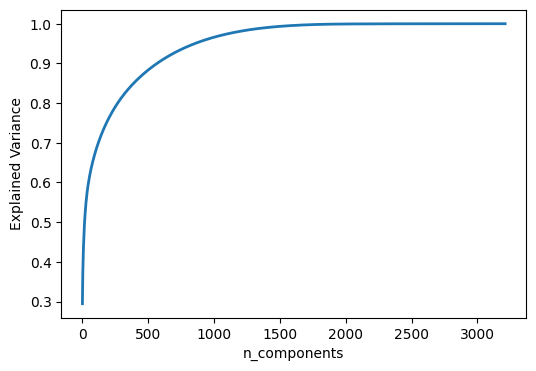

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=train_df_norm_w_hog_features_and_lbp.shape[1])
pca_result_784 = pca.fit_transform(train_df_norm_w_hog_features_and_lbp.values)
var_ratios = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6, 4))
plt.plot(var_ratios, linewidth=2)
plt.xlabel("n_components")
plt.ylabel("Explained Variance")
plt.show()

In [6]:
pca = PCA(n_components=1350) # around 1750 features explain 100% of data
pca_result = pca.fit_transform(train_df_norm_w_hog_features_and_lbp.values)

In [7]:
pca_df = pd.DataFrame(pca_result, columns=[f"pca_{i}" for i in range(pca_result.shape[1])])
pca_df

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_1340,pca_1341,pca_1342,pca_1343,pca_1344,pca_1345,pca_1346,pca_1347,pca_1348,pca_1349
0,-8.504364,1.515702,1.014913,4.945100,-0.593541,-0.719234,1.486656,-1.968715,0.501344,2.606954,...,0.088217,0.012795,0.018714,-0.034326,-0.110468,-0.048745,0.069677,-0.157030,0.097019,-0.098670
1,-8.436155,1.513105,0.925572,4.222497,-0.592088,-0.470508,1.075719,-1.608832,0.362796,1.923331,...,0.010912,0.024847,0.091078,0.023547,0.098393,0.015109,0.007186,-0.013029,0.011372,0.059293
2,-8.252612,1.516204,1.041370,4.806250,-0.628859,-0.738681,1.471501,-1.902434,0.481380,2.491124,...,0.075200,0.050555,0.029707,-0.054140,-0.106652,-0.054867,0.102995,-0.166360,0.092194,-0.099744
3,-7.922526,2.802216,1.148599,3.246962,-0.001019,-0.231790,-1.332404,-1.086357,-1.081422,0.883567,...,-0.054030,-0.203677,0.045185,0.153478,-0.160266,0.198524,0.133358,-0.030131,-0.169580,-0.314261
4,-8.115534,0.120520,1.518657,5.594979,0.776508,-0.940090,-0.111901,0.272427,0.576799,3.439679,...,0.060227,0.023819,-0.049501,0.057412,-0.108616,-0.017076,0.133535,-0.022100,-0.038293,-0.083614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92794,-8.345122,0.566860,0.201356,-2.885688,1.117897,-2.187195,2.663400,1.328062,2.149530,-1.809642,...,0.041823,-0.044383,-0.025411,0.034361,-0.049291,-0.022699,-0.085630,0.024503,0.062219,0.030117
92795,-7.970663,1.988773,0.216199,-3.610357,2.662641,-3.295377,-1.479316,0.075959,0.891454,-1.426460,...,0.000553,-0.168991,-0.040433,-0.023760,-0.061407,-0.119802,-0.050052,0.085357,-0.118312,-0.071222
92796,-7.519286,-0.897727,-1.454774,-2.864768,0.226334,0.256282,2.462036,0.576806,-1.891031,-0.876950,...,-0.002088,0.118226,-0.003550,0.113636,-0.001398,0.178795,-0.057898,0.048130,0.113393,-0.004669
92797,-8.263281,1.555613,0.599196,-0.093759,-0.726241,0.101174,1.384867,1.115090,-1.808555,0.233074,...,0.139309,-0.128745,0.059396,0.035414,0.038841,0.030531,0.085199,0.041086,-0.008051,-0.076821


In [8]:
big_df_w_pca_feats = pd.concat([train_df_norm_w_hog_features_and_lbp, pca_df], axis=1)

In [9]:
big_df_w_pca_feats

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pca_1340,pca_1341,pca_1342,pca_1343,pca_1344,pca_1345,pca_1346,pca_1347,pca_1348,pca_1349
0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.088217,0.012795,0.018714,-0.034326,-0.110468,-0.048745,0.069677,-0.157030,0.097019,-0.098670
1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.010912,0.024847,0.091078,0.023547,0.098393,0.015109,0.007186,-0.013029,0.011372,0.059293
2,0.0,0.000000,0.0,0.047059,0.035294,0.000000,0.035294,0.019608,0.003922,0.0,...,0.075200,0.050555,0.029707,-0.054140,-0.106652,-0.054867,0.102995,-0.166360,0.092194,-0.099744
3,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-0.054030,-0.203677,0.045185,0.153478,-0.160266,0.198524,0.133358,-0.030131,-0.169580,-0.314261
4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.060227,0.023819,-0.049501,0.057412,-0.108616,-0.017076,0.133535,-0.022100,-0.038293,-0.083614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92794,0.0,0.023529,0.0,0.000000,0.000000,0.043137,0.011765,0.003922,0.000000,0.0,...,0.041823,-0.044383,-0.025411,0.034361,-0.049291,-0.022699,-0.085630,0.024503,0.062219,0.030117
92795,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000553,-0.168991,-0.040433,-0.023760,-0.061407,-0.119802,-0.050052,0.085357,-0.118312,-0.071222
92796,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-0.002088,0.118226,-0.003550,0.113636,-0.001398,0.178795,-0.057898,0.048130,0.113393,-0.004669
92797,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.139309,-0.128745,0.059396,0.035414,0.038841,0.030531,0.085199,0.041086,-0.008051,-0.076821


# Multi-Class LR**

In [10]:
alpha_map = {ele: i+10 for i, ele in enumerate(np.unique(labels_df_augmented.values)[10:])}
for i in range(0, 10):
    alpha_map[str(i)] = i
alpha_map

{'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'J': 19,
 'K': 20,
 'L': 21,
 'M': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'Q': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'W': 32,
 'X': 33,
 'Y': 34,
 'Z': 35,
 '0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [11]:
labels_df_augmented

,label
0,N
1,N
2,N
3,N
4,N
...,...
92794,J
92795,J
92796,J
92797,J


In [12]:
labels_df_augmented["label"] = labels_df_augmented["label"].map(alpha_map)

In [13]:
# X = train_df_norm_w_hog_features_and_lbp.values
X = train_df_norm_w_hog_features_and_lbp.values
y = labels_df_augmented["label"].values

In [ ]:
class MultiClassLogisticRegression:
    def __init__(self, input_dim, num_classes):
        self.W = np.random.rand(input_dim, num_classes)  # Initialize weights
        self.b = np.random.rand(num_classes)  # Initialize biases
        self.num_classes = num_classes

    def softmax(self, z):
        e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return e_z / e_z.sum(axis=1, keepdims=True)

    def predict(self, X):
        z = np.dot(X, self.W) + self.b
        return self.softmax(z)

def categorical_cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / len(y_true)
    return loss

In [ ]:
num_classes = 36
model = MultiClassLogisticRegression(X.shape[1], num_classes)
def one_hot_encode(labels, num_classes):
    num_samples = len(labels)
    encoded_labels = np.zeros((num_samples, num_classes))
    
    for i in range(num_samples):
        label = labels[i]
        encoded_labels[i, label] = 1
    
    return encoded_labels

y_enc = one_hot_encode(y, 36)

In [ ]:
# lr = 0.5
# epochs = 5000
# for epoch in range(epochs):
#     predictions = model.predict(X)
#     loss = categorical_cross_entropy_loss(y_enc, predictions)

#     dW = np.dot(X.T, (predictions - y_enc)) / X.shape[0]  # transpose because differentiaing a matrix also transposes it
#     db = np.sum(predictions - y_enc, axis=0) / X.shape[0]
    
#     if loss < 0.3:
#         lr = 0.15

#     model.W -= lr * dW
#     model.b -= lr * db

#     if epoch%500==0:
#         print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")

In [ ]:
# lr = 0.1
# epochs = 2000
# for epoch in range(epochs):
#     predictions = model.predict(X)
#     loss = categorical_cross_entropy_loss(y_enc, predictions)

#     dW = np.dot(X.T, (predictions - y_enc)) / X.shape[0]
#     db = np.sum(predictions - y_enc, axis=0) / X.shape[0]
    
#     model.W -= lr * dW
#     model.b -= lr * db

#     if epoch%500==0:
#         print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")

In [ ]:
# np.save("mclr_w.npy", model.W)
# np.save("mclr_b.npy", model.b)

In [ ]:
W = np.load("/kaggle/input/mclr-with-augs/mclr_w.npy")
b = np.load("/kaggle/input/mclr-with-augs/mclr_b.npy")

model.W = W
model.b = b

In [ ]:
# from sklearn.model_selection import KFold
# K = 5
# kf = KFold(n_splits=K, shuffle=True, random_state=42)

# y = labels_df_augmented


# svm_scores = []
# knn_scores = []
# rf_scores = []
# knn = KNeighborsClassifier(n_neighbors=5)
# svm_clf = SVC(kernel='linear', random_state=42, probability=True)
# rf_clf = RandomForestClassifier(n_estimators=100,random_state=22,max_depth=10,min_samples_split=5,max_leaf_nodes=100)

# for train_index, test_index in kf.split(train_df_norm_w_hog_features_and_lbp):
    
#     X_train, X_test = train_df_norm_w_hog_features_and_lbp.iloc[train_index], train_df_norm_w_hog_features_and_lbp.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     svm_clf.fit(X_train, y_train)
#     svm_predictions = svm_clf.predict(X_test)
#     svm_scores.append(accuracy_score(y_test, svm_predictions))
    
# for train_index, test_index in kf.split(big_df_w_pca_feats):
#     X_train, X_test = big_df_w_pca_feats.iloc[train_index], big_df_w_pca_feats.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     knn.fit(X_train, y_train)
#     knn_predictions = knn.predict(X_test)
#     knn_scores.append(accuracy_score(y_test, knn_predictions))


#     rf_clf.fit(X_train, y_train)
#     rf_predictions = rf_clf.predict(X_test)
#     rf_scores.append(accuracy_score(y_test, rf_predictions))

# average_svm_score = sum(svm_scores) / K
# average_knn_score = sum(knn_scores) / K
# average_rf_score = sum(rf_scores) / K

# print(f"Average SVM Score: {average_svm_score}")
# print(f"Average KNN Score: {average_knn_score}")
# print(f"Average RF Score: {average_rf_score}")

In [14]:
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(train_df_norm_w_hog_features_and_lbp, labels_df_augmented.values, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(big_df_w_pca_feats, labels_df_augmented.values, test_size=0.2, random_state=42)

In [ ]:
# train_df_norm_w_hog_features_and_lbp

In [15]:
from sklearn.linear_model import LogisticRegression
# Logisitc regression multiclass
lrcf = LogisticRegression(multi_class="multinomial", max_iter=500, verbose=1)
lrcf.fit(X_train_st, y_train_st) 

y_pred = lrcf.predict(X_test_st)
accuracy = accuracy_score(y_test_st, y_pred)
print("Accuracy score with hog features concat to normalised df:", accuracy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       115668     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66037D+05    |proj g|=  7.13999D+02


 This problem is unconstrained.



At iterate   50    f=  3.91651D+04    |proj g|=  1.98332D+02

At iterate  100    f=  1.86117D+04    |proj g|=  3.65490D+01

At iterate  150    f=  1.24322D+04    |proj g|=  2.86051D+01

At iterate  200    f=  1.07169D+04    |proj g|=  1.65808D+01

At iterate  250    f=  1.00176D+04    |proj g|=  1.16125D+01

At iterate  300    f=  9.62013D+03    |proj g|=  9.67262D+00

At iterate  350    f=  9.36039D+03    |proj g|=  8.38446D+00

At iterate  400    f=  9.19101D+03    |proj g|=  2.63741D+01

At iterate  450    f=  9.09215D+03    |proj g|=  8.35386D+00

At iterate  500    f=  9.02427D+03    |proj g|=  4.99765D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.7min finished


Accuracy score with hog features concat to normalised df: 0.853125


In [16]:
%%time
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100,random_state=22,max_depth=10,min_samples_split=5,max_leaf_nodes=100)
rf_clf.fit(X_train, y_train) 

y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score with hog features concat to normalised df:", accuracy)

<timed exec>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy score with hog features concat to normalised df: 0.7700431034482759
CPU times: user 3min 8s, sys: 6.3 s, total: 3min 14s
Wall time: 3min 15s
Parser   : 138 ms


In [17]:
%%time
# SVM Classifier
svm_clf = SVC(kernel='linear', random_state=42, probability=True)
svm_clf.fit(X_train_st, y_train_st)
y_pred = svm_clf.predict(X_test_st)

accuracy = accuracy_score(y_test_st, y_pred)
print("Accuracy score with hog features concat to normalised df (SVC):", accuracy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score with hog features concat to normalised df (SVC): 0.8753771551724138
CPU times: user 4h 22min 23s, sys: 2min 22s, total: 4h 24min 45s
Wall time: 4h 26min 53s


In [18]:
%%time
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score:", accuracy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy score: 0.8172413793103448
CPU times: user 7min 14s, sys: 7.15 s, total: 7min 22s
Wall time: 1min


In [19]:
import joblib

joblib.dump(svm_clf, "svm.pkl")
joblib.dump(rf_clf, "rf.pkl")
joblib.dump(knn, "knn.pkl")
joblib.dump(lrcf, "lrcf.pkl")

['lrcf.pkl']

# INFERENCE

In [22]:
class_folders = [folder for folder in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, folder))]

classwise_imgs_paths = []
for image_dir in class_folders:
    p = [os.path.join(test_path, image_dir, filename) for filename in os.listdir(os.path.join(test_path, image_dir)) if filename.endswith(('.jpg', '.png'))]
    classwise_imgs_paths.append(p)


In [53]:
class_folders

['R',
 'U',
 '9',
 '0',
 '7',
 'I',
 'N',
 'G',
 '6',
 'Z',
 '1',
 '8',
 'T',
 'S',
 'A',
 'F',
 'O',
 'H',
 'M',
 'J',
 'C',
 'D',
 'V',
 'Q',
 '4',
 'X',
 '3',
 'E',
 'B',
 'K',
 'L',
 '2',
 'Y',
 '5',
 'P',
 'W']

In [23]:
data_test = []
data_test_norm = []
data_edge_test = []
tru_labels = []
for c in classwise_imgs_paths:
    for image_p in c:
#         print(image_p)
        img = Image.open(image_p)
        img = img.convert('L')
        img = img.resize((38, 38), Image.Resampling.LANCZOS)
        img_arr = np.array(img).flatten()
        img_arr_norm = np.array(img).flatten() / 255.0
        edge_arr = compute_edges(np.array(img))
        edge_arr_pil = Image.fromarray(edge_arr)
        edge_arr_pil = edge_arr_pil.resize((38, 38), Image.Resampling.LANCZOS)
        edge_arr = np.array(edge_arr_pil).flatten()
        cl = image_p.split("/")[-2]
        tru_labels.append(cl)
        data_test.append(img_arr)
        data_test_norm.append(img_arr_norm)        
        data_edge_test.append(edge_arr)

In [25]:
pixel_cols = [f'pixel_{i}' for i in range(np.array(data_test).shape[1])]
edge_cols = [f'edge_{i}' for i in range(np.array(data_edge_test).shape[1])]

In [26]:
data_df_test = pd.DataFrame(data_test, columns=pixel_cols)
data_df_norm_test = pd.DataFrame(data_test_norm, columns=pixel_cols)
test_df_edge = pd.DataFrame(data_edge_test, columns=edge_cols)
labels_df_test = pd.DataFrame(tru_labels)
data_df_test

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_1434,pixel_1435,pixel_1436,pixel_1437,pixel_1438,pixel_1439,pixel_1440,pixel_1441,pixel_1442,pixel_1443
0,217,214,213,208,206,207,207,207,205,204,...,162,160,158,157,157,159,172,188,205,215
1,225,225,225,222,219,218,218,218,218,216,...,228,224,216,213,212,211,214,220,226,229
2,209,209,205,201,199,197,195,196,199,201,...,189,188,189,191,197,202,205,205,206,208
3,215,215,213,212,214,215,213,210,213,211,...,212,209,194,188,188,191,197,203,212,219
4,169,172,173,169,163,161,161,162,162,160,...,170,165,160,159,157,155,159,167,171,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,181,177,170,172,171,171,172,176,181,182,...,128,142,169,183,182,182,184,184,183,180
1004,228,222,219,217,225,229,228,224,227,225,...,221,227,229,229,229,225,228,227,226,227
1005,218,215,213,209,203,207,206,204,213,218,...,185,203,214,215,213,219,218,217,216,217
1006,244,244,239,233,229,226,231,230,229,231,...,172,170,173,188,212,235,243,247,245,245


In [27]:
test_df_edge = test_df_edge.replace({True: 1, False: 0})
test_df_edge

,edge_0,edge_1,edge_2,edge_3,edge_4,edge_5,edge_6,edge_7,edge_8,edge_9,...,edge_1434,edge_1435,edge_1436,edge_1437,edge_1438,edge_1439,edge_1440,edge_1441,edge_1442,edge_1443
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:

hog_features_test = np.array([extract_hog_features(image.reshape(38, 38)) for image in data_df_test.values])
# lbp_features_test = np.array([extract_lbp_features(image.reshape(38, 38)) for image in data_df_test.values])
hog_cols = [f'hog_{i}' for i in range(hog_features_test.shape[1])]

hog_features_df_test = pd.DataFrame(hog_features_test, columns=hog_cols)
# lbp_features_df_test = pd.DataFrame(lbp_features_test, columns=lbp_cols)
test_df_norm_w_hog_features_and_lbp = pd.concat([data_df_norm_test, hog_features_df_test, test_df_edge], axis=1)

In [34]:
test_df_norm_w_hog_features_and_lbp

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,edge_1434,edge_1435,edge_1436,edge_1437,edge_1438,edge_1439,edge_1440,edge_1441,edge_1442,edge_1443
0,0.850980,0.839216,0.835294,0.815686,0.807843,0.811765,0.811765,0.811765,0.803922,0.800000,...,0,0,0,0,0,0,0,0,0,0
1,0.882353,0.882353,0.882353,0.870588,0.858824,0.854902,0.854902,0.854902,0.854902,0.847059,...,0,0,0,0,0,0,0,0,0,0
2,0.819608,0.819608,0.803922,0.788235,0.780392,0.772549,0.764706,0.768627,0.780392,0.788235,...,0,0,0,0,0,0,0,0,0,0
3,0.843137,0.843137,0.835294,0.831373,0.839216,0.843137,0.835294,0.823529,0.835294,0.827451,...,0,0,0,0,0,0,0,0,0,0
4,0.662745,0.674510,0.678431,0.662745,0.639216,0.631373,0.631373,0.635294,0.635294,0.627451,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,0.709804,0.694118,0.666667,0.674510,0.670588,0.670588,0.674510,0.690196,0.709804,0.713725,...,0,0,0,0,0,0,0,0,0,0
1004,0.894118,0.870588,0.858824,0.850980,0.882353,0.898039,0.894118,0.878431,0.890196,0.882353,...,0,0,0,0,0,0,0,0,0,0
1005,0.854902,0.843137,0.835294,0.819608,0.796078,0.811765,0.807843,0.800000,0.835294,0.854902,...,0,0,0,0,0,0,0,0,0,0
1006,0.956863,0.956863,0.937255,0.913725,0.898039,0.886275,0.905882,0.901961,0.898039,0.905882,...,0,0,0,0,0,0,0,0,0,0


In [35]:
pca_result_tst = pca.transform(test_df_norm_w_hog_features_and_lbp.values)
pca_df_tst = pd.DataFrame(pca_result_tst, columns=[f"pca_{i}" for i in range(pca_result_tst.shape[1])])
pca_df_tst

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_1340,pca_1341,pca_1342,pca_1343,pca_1344,pca_1345,pca_1346,pca_1347,pca_1348,pca_1349
0,8.278196,4.223008,-3.063845,-3.268642,2.022399,-0.432163,-0.939442,-0.557109,2.852268,-0.608894,...,0.037514,-0.105689,-0.026793,0.063319,-0.156539,0.074181,-0.083997,-0.017618,0.019913,0.020900
1,15.568604,-3.693976,-2.260984,-1.817404,-0.910209,-0.931588,-1.591291,-0.672271,1.530855,-1.058687,...,-0.088344,0.154111,-0.016602,0.058138,-0.208201,-0.005940,0.001800,-0.076551,0.063391,-0.139899
2,10.784931,1.916630,-1.695061,-2.716734,1.327385,-0.704366,-1.679815,-1.708255,2.392713,-1.067113,...,-0.031490,-0.121712,-0.126138,-0.157483,-0.105172,-0.028038,0.018001,-0.111684,0.061785,-0.152305
3,15.352462,-3.145088,-1.178574,-1.350467,-1.026593,-1.814835,-1.222417,-0.580599,1.514908,-0.432087,...,0.155736,-0.014319,-0.179621,-0.039298,-0.114806,-0.146387,0.017054,-0.021245,0.024642,0.004541
4,8.522851,-0.966149,-1.358579,-1.991135,-0.293597,-0.981794,-1.454990,-0.450333,2.110023,-1.705613,...,-0.006718,0.032255,0.064078,0.139820,-0.096763,-0.053245,-0.138288,0.022373,-0.089356,-0.131544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,6.211103,4.810280,1.425206,-0.424289,-0.737427,-2.179985,0.006843,2.373643,4.091108,0.064481,...,0.070759,0.049477,-0.122415,0.058839,-0.006592,0.109511,0.032201,0.019616,-0.082245,0.059084
1004,16.642459,-3.605647,0.630964,0.749283,-2.005014,-1.716705,-0.289116,1.284826,2.008845,1.000819,...,-0.182835,0.072867,-0.185457,0.057531,-0.310665,0.117565,-0.117334,-0.058052,-0.297328,-0.186933
1005,11.810891,1.921229,1.373384,-0.159096,-0.498553,-1.465570,-0.204369,0.173945,4.095766,-0.183582,...,0.183390,0.074546,0.173417,-0.044511,-0.020343,-0.043719,-0.146382,0.104808,0.091402,-0.136137
1006,8.534717,7.358847,1.599065,-1.259471,0.565802,-0.522134,0.182490,0.267229,4.365537,0.082389,...,0.205297,0.190807,0.180906,0.039604,-0.049427,0.154806,-0.303392,0.126390,0.079149,-0.300695


In [36]:
big_df_w_pca_feats_test = pd.concat([test_df_norm_w_hog_features_and_lbp, pca_df_tst], axis=1)

In [39]:
# test_predictions = model.predict(test_df_norm_w_hog_features_and_lbp.values)
# answers = np.argmax(test_predictions, axis=1)
mapped_labels_df = pd.DataFrame()
mapped_labels_df["label"] = labels_df_test[0].map(alpha_map)

In [ ]:
# correct = 0
# tot = 0
# for i in range(len(answers)):
#     if answers[i] == mapped_labels_df["label"].values[i]:
#         correct +=1
#     tot +=1
# print(f"Accuracy = {(correct/tot)*100}%")

In [40]:
y_pred_rnd_for = rf_clf.predict(big_df_w_pca_feats_test)

accuracy_forest = accuracy_score(mapped_labels_df["label"].values, y_pred_rnd_for)
print("Accuracy on testing data:", accuracy_forest)

Accuracy on testing data: 0.9573412698412699


In [41]:
y_pred_svm = svm_clf.predict(test_df_norm_w_hog_features_and_lbp)

accuracy_svm = accuracy_score(mapped_labels_df["label"].values, y_pred_svm)
print("Accuracy on testing data:", accuracy_svm)

Accuracy on testing data: 0.9851190476190477


In [42]:
y_pred_lrcf = lrcf.predict(test_df_norm_w_hog_features_and_lbp)

accuracy_lrcf = accuracy_score(mapped_labels_df["label"].values, y_pred_lrcf)
print("Accuracy on testing data:", accuracy_lrcf)

Accuracy on testing data: 0.9851190476190477


In [43]:
y_pred_knn = knn.predict(big_df_w_pca_feats_test)

accuracy_knn = accuracy_score(mapped_labels_df["label"].values, y_pred_knn)
print("Accuracy on testing data:", accuracy_knn)

Accuracy on testing data: 0.9801587301587301


## Trying out stacking

In [44]:
# svm_predictions = svm_clf.predict_proba(train_df_norm_w_hog_features_and_lbp)
# rf_predictions = rf_clf.predict_proba(train_df_norm_w_hog_features_and_lbp)
# knn_predictions = knn.predict_proba(train_df_norm_w_hog_features_and_lbp)
# mclr_predictions = model.predict(X)
svm_predictions = svm_clf.predict_proba(train_df_norm_w_hog_features_and_lbp)
rf_predictions = rf_clf.predict_proba(big_df_w_pca_feats)
knn_predictions = knn.predict_proba(big_df_w_pca_feats)
# mclr_predictions = model.predict(train_df_norm_w_hog_features_and_lbp)
lrcf_predictions = lrcf.predict_proba(train_df_norm_w_hog_features_and_lbp)
stacking_data = np.column_stack((svm_predictions, rf_predictions, knn_predictions, lrcf_predictions))

In [ ]:
# final_pred = (svm_predictions+rf_predictions+knn_predictions+mclr_predictions)/4.0
# answers_preds = np.argmax(final_pred, axis=1)
# correct = 0
# tot = 0
# for i in range(len(answers_preds)):
#     if answers_preds[i] == mapped_labels_df["label"].values[i]:
#         correct +=1
#     tot +=1
# print(f"Accuracy = {(correct/tot)*100}%")

In [ ]:
# final_pred.shape

In [45]:
meta_model = SVC(kernel='linear', random_state=42, probability=True)
meta_model.fit(stacking_data, labels_df_augmented)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear', probability=True, random_state=42)

In [46]:
test_svm_predictions = svm_clf.predict_proba(test_df_norm_w_hog_features_and_lbp)
test_rf_predictions = rf_clf.predict_proba(big_df_w_pca_feats_test)
test_knn_predictions = knn.predict_proba(big_df_w_pca_feats_test)
# test_mclr_predictions = model.predict(test_df_norm_w_hog_features_and_lbp)
test_lrcf_predictions = lrcf.predict_proba(test_df_norm_w_hog_features_and_lbp)

In [47]:
stacking_data_test = np.column_stack((test_svm_predictions, test_rf_predictions, test_knn_predictions, test_lrcf_predictions))
final_predictions = meta_model.predict(stacking_data_test)

In [48]:
final_predictions

array([27, 27, 27, ..., 32, 32, 32])

In [52]:
correct = 0
tot = 0
for i in range(len(final_predictions)):
    if final_predictions[i] == mapped_labels_df["label"].values[i]:
        correct +=1
    else:
        print(final_predictions[i],mapped_labels_df["label"].values[i])
    tot +=1
    
print(f"Accuracy = {(correct/tot)*100}%")

11 27
24 0
24 0
0 24
0 24
0 24
Accuracy = 99.40476190476191%


In [50]:
joblib.dump(meta_model, "meta_model.pkl")

['meta_model.pkl']

In [51]:
joblib.dump(pca, "pca_1350.pkl")

['pca_1350.pkl']